<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-to-Regularization" data-toc-modified-id="Introduction-to-Regularization-1">Introduction to Regularization</a></span><ul class="toc-item"><li><span><a href="#Explore-the-Data" data-toc-modified-id="Explore-the-Data-1.1">Explore the Data</a></span></li></ul></li><li><span><a href="#Important-facts-about-regularization" data-toc-modified-id="Important-facts-about-regularization-2">Important facts about regularization</a></span></li><li><span><a href="#Unscaled-data" data-toc-modified-id="Unscaled-data-3">Unscaled data</a></span></li><li><span><a href="#Scaled-data" data-toc-modified-id="Scaled-data-4">Scaled data</a></span></li></ul></div>

# Introduction to Regularization

<a href="https://drive.google.com/file/d/1EZ_xqMaYj77vErVnrQmnFOj-VBEoO5uW/view" target="_blank">
     <img src="http://www.deltanalytics.org/uploads/2/6/1/4/26140521/screen-shot-2019-01-05-at-4-48-29-pm_orig.png" width="500" height="400">
</a>

In the context of regression, regularization refers to techniques to constrain/shrink the coefficient estimates towards zero.  
Shrinking the coefficients can 1) improve the fit of the model and 2) reduce the variance of the coefficients.

Two common types of regularization are ridge and lasso.  

Recall that least squares linear regression minimizes the residual sum of squares (RSS).  In other words, it minimizes

$ RSS = \displaystyle \sum^{n}_{i=1} (y_i - \beta_0 - \sum^{p}_{j=1} \beta_j x_{ij})^2 $

In ridge and lasso, we add a term to the value we are trying to minimize.  

In ridge, we minimize 

$ RSS + \lambda \displaystyle \sum^{p}_{j=1} \beta_j^2 $


**Intuition:** We want to minmize our coefficients so we are not multiplying by huge values, hence the **square** term. **Ridge dislikes ridiculously large values** but it is okay with medium values.

In lasso, we minimize

$ RSS + \lambda \displaystyle \sum^{p}_{j=1} |\beta_j| $

**Intuition:** We want to remove and minimize the coefficients for features/variables that are not informative to our predictions. This form of regularization performs "automatic" feature selection. **LASSO rings in important features** and drives other coefficients to zero.

The $\lambda$ (pronounced "lambda") in the above values is a hyper-parameter which determines how 'strong' the regularization effect is.  Note: sometimes $\alpha$ (pronounced "alpha") is used instead of $\lambda$.

A useful way to use ridge or lasso regression is to run the regression over a range of alphas and see which features maintain a large beta coefficient for the longest. It is these features which have the most predictive power!

More in depth information can be found here: [Regularization Regression](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)

In [52]:
reset -fs

In [53]:
# Generally useful data science packages
import numpy as np
import pandas as pd

# Plotting package
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

# We'll be using statsmodels to fit linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

# packages for regularization
from sklearn.linear_model import Lasso
from math import pow, sqrt

np.random.seed(1234)

Explore the Data
---

In [54]:
# Load data

try: 
    # Local version
    path = "../data/"
    filename = 'loans.csv'
    df = pd.read_csv(path+filename)
except FileNotFoundError or ParserError: 
    # If not local, get from remote repp. Helpful if using colab.
    url = 'https://raw.githubusercontent.com/DeltaAnalytics/machine_learning_for_good_data/master/loans.csv'
    df = pd.read_csv(url)

In [55]:
df.dtypes

id_number                 int64
loan_amount               int64
lender_count              int64
status                   object
funded_date              object
funded_amount             int64
repayment_term            int64
location_country_code    object
sector                   object
description              object
use                      object
dtype: object

In [56]:
# create indicator variables for country
for country in df['location_country_code'].unique():
    if country is not np.nan:
        df['country_'+country] = np.where(df.location_country_code == country, 1, 0)

In [57]:
# create indicator variables for sector
for sect in df['sector'].unique():
    df['sector_'+sect] = np.where(df.sector == sect, 1, 0)

In [58]:
df.dtypes

id_number                 int64
loan_amount               int64
lender_count              int64
status                   object
funded_date              object
funded_amount             int64
repayment_term            int64
location_country_code    object
sector                   object
description              object
use                      object
country_BJ                int64
country_BW                int64
country_BF                int64
country_BI                int64
country_CM                int64
country_CG                int64
country_CD                int64
country_EG                int64
country_GH                int64
country_CI                int64
country_KE                int64
country_LS                int64
country_LR                int64
country_MG                int64
country_MW                int64
country_ML                int64
country_MR                int64
country_MZ                int64
country_NG                int64
country_RW                int64
country_

In [59]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define the dependent variable
y = df['loan_amount']
# Define the independent variables
X = df[['lender_count', 'sector_Education', 'sector_Clothing', 
        'sector_Personal Use', 'sector_Retail', 'sector_Transportation', 'sector_Agriculture']]
# Add an intercept term to the independent variables
X['cnst'] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     3031.
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:12:39   Log-Likelihood:                -40379.
No. Observations:                4815   AIC:                         8.077e+04
Df Residuals:                    4807   BIC:                         8.083e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
lender_count             31.11

In [60]:
alphas = np.arange(0.001, 0.502, 0.002)
lasso_coefs = []
X_train_lasso= X_train[X_train.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True, normalize=True)
    lassoreg.fit(X_train_lasso, y_train)
    lasso_coefs.append(lassoreg.coef_)

Lasso(alpha=0.001, normalize=True)

Lasso(alpha=0.003, normalize=True)

Lasso(alpha=0.005, normalize=True)

Lasso(alpha=0.007, normalize=True)

Lasso(alpha=0.009000000000000001, normalize=True)

Lasso(alpha=0.011, normalize=True)

Lasso(alpha=0.013000000000000001, normalize=True)

Lasso(alpha=0.015, normalize=True)

Lasso(alpha=0.017, normalize=True)

Lasso(alpha=0.019000000000000003, normalize=True)

Lasso(alpha=0.021, normalize=True)

Lasso(alpha=0.023, normalize=True)

Lasso(alpha=0.025, normalize=True)

Lasso(alpha=0.027000000000000003, normalize=True)

Lasso(alpha=0.029, normalize=True)

Lasso(alpha=0.031, normalize=True)

Lasso(alpha=0.033, normalize=True)

Lasso(alpha=0.035, normalize=True)

Lasso(alpha=0.037000000000000005, normalize=True)

Lasso(alpha=0.039, normalize=True)

Lasso(alpha=0.041, normalize=True)

Lasso(alpha=0.043000000000000003, normalize=True)

Lasso(alpha=0.045, normalize=True)

Lasso(alpha=0.047, normalize=True)

Lasso(alpha=0.049, normalize=True)

Lasso(alpha=0.051000000000000004, normalize=True)

Lasso(alpha=0.053000000000000005, normalize=True)

Lasso(alpha=0.055, normalize=True)

Lasso(alpha=0.057, normalize=True)

Lasso(alpha=0.059000000000000004, normalize=True)

Lasso(alpha=0.061, normalize=True)

Lasso(alpha=0.063, normalize=True)

Lasso(alpha=0.065, normalize=True)

Lasso(alpha=0.067, normalize=True)

Lasso(alpha=0.069, normalize=True)

Lasso(alpha=0.07100000000000001, normalize=True)

Lasso(alpha=0.07300000000000001, normalize=True)

Lasso(alpha=0.075, normalize=True)

Lasso(alpha=0.077, normalize=True)

Lasso(alpha=0.079, normalize=True)

Lasso(alpha=0.081, normalize=True)

Lasso(alpha=0.083, normalize=True)

Lasso(alpha=0.085, normalize=True)

Lasso(alpha=0.08700000000000001, normalize=True)

Lasso(alpha=0.089, normalize=True)

Lasso(alpha=0.091, normalize=True)

Lasso(alpha=0.093, normalize=True)

Lasso(alpha=0.095, normalize=True)

Lasso(alpha=0.097, normalize=True)

Lasso(alpha=0.099, normalize=True)

Lasso(alpha=0.101, normalize=True)

Lasso(alpha=0.10300000000000001, normalize=True)

Lasso(alpha=0.10500000000000001, normalize=True)

Lasso(alpha=0.107, normalize=True)

Lasso(alpha=0.109, normalize=True)

Lasso(alpha=0.111, normalize=True)

Lasso(alpha=0.113, normalize=True)

Lasso(alpha=0.115, normalize=True)

Lasso(alpha=0.117, normalize=True)

Lasso(alpha=0.11900000000000001, normalize=True)

Lasso(alpha=0.121, normalize=True)

Lasso(alpha=0.123, normalize=True)

Lasso(alpha=0.125, normalize=True)

Lasso(alpha=0.127, normalize=True)

Lasso(alpha=0.129, normalize=True)

Lasso(alpha=0.131, normalize=True)

Lasso(alpha=0.133, normalize=True)

Lasso(alpha=0.135, normalize=True)

Lasso(alpha=0.137, normalize=True)

Lasso(alpha=0.139, normalize=True)

Lasso(alpha=0.14100000000000001, normalize=True)

Lasso(alpha=0.14300000000000002, normalize=True)

Lasso(alpha=0.14500000000000002, normalize=True)

Lasso(alpha=0.147, normalize=True)

Lasso(alpha=0.149, normalize=True)

Lasso(alpha=0.151, normalize=True)

Lasso(alpha=0.153, normalize=True)

Lasso(alpha=0.155, normalize=True)

Lasso(alpha=0.157, normalize=True)

Lasso(alpha=0.159, normalize=True)

Lasso(alpha=0.161, normalize=True)

Lasso(alpha=0.163, normalize=True)

Lasso(alpha=0.165, normalize=True)

Lasso(alpha=0.167, normalize=True)

Lasso(alpha=0.169, normalize=True)

Lasso(alpha=0.171, normalize=True)

Lasso(alpha=0.17300000000000001, normalize=True)

Lasso(alpha=0.17500000000000002, normalize=True)

Lasso(alpha=0.177, normalize=True)

Lasso(alpha=0.179, normalize=True)

Lasso(alpha=0.181, normalize=True)

Lasso(alpha=0.183, normalize=True)

Lasso(alpha=0.185, normalize=True)

Lasso(alpha=0.187, normalize=True)

Lasso(alpha=0.189, normalize=True)

Lasso(alpha=0.191, normalize=True)

Lasso(alpha=0.193, normalize=True)

Lasso(alpha=0.195, normalize=True)

Lasso(alpha=0.197, normalize=True)

Lasso(alpha=0.199, normalize=True)

Lasso(alpha=0.201, normalize=True)

Lasso(alpha=0.203, normalize=True)

Lasso(alpha=0.20500000000000002, normalize=True)

Lasso(alpha=0.20700000000000002, normalize=True)

Lasso(alpha=0.20900000000000002, normalize=True)

Lasso(alpha=0.211, normalize=True)

Lasso(alpha=0.213, normalize=True)

Lasso(alpha=0.215, normalize=True)

Lasso(alpha=0.217, normalize=True)

Lasso(alpha=0.219, normalize=True)

Lasso(alpha=0.221, normalize=True)

Lasso(alpha=0.223, normalize=True)

Lasso(alpha=0.225, normalize=True)

Lasso(alpha=0.227, normalize=True)

Lasso(alpha=0.229, normalize=True)

Lasso(alpha=0.231, normalize=True)

Lasso(alpha=0.233, normalize=True)

Lasso(alpha=0.23500000000000001, normalize=True)

Lasso(alpha=0.23700000000000002, normalize=True)

Lasso(alpha=0.23900000000000002, normalize=True)

Lasso(alpha=0.241, normalize=True)

Lasso(alpha=0.243, normalize=True)

Lasso(alpha=0.245, normalize=True)

Lasso(alpha=0.247, normalize=True)

Lasso(alpha=0.249, normalize=True)

Lasso(alpha=0.251, normalize=True)

Lasso(alpha=0.253, normalize=True)

Lasso(alpha=0.255, normalize=True)

Lasso(alpha=0.257, normalize=True)

Lasso(alpha=0.259, normalize=True)

Lasso(alpha=0.261, normalize=True)

Lasso(alpha=0.263, normalize=True)

Lasso(alpha=0.265, normalize=True)

Lasso(alpha=0.267, normalize=True)

Lasso(alpha=0.269, normalize=True)

Lasso(alpha=0.271, normalize=True)

Lasso(alpha=0.273, normalize=True)

Lasso(alpha=0.275, normalize=True)

Lasso(alpha=0.277, normalize=True)

Lasso(alpha=0.279, normalize=True)

Lasso(alpha=0.281, normalize=True)

Lasso(alpha=0.28300000000000003, normalize=True)

Lasso(alpha=0.28500000000000003, normalize=True)

Lasso(alpha=0.28700000000000003, normalize=True)

Lasso(alpha=0.28900000000000003, normalize=True)

Lasso(alpha=0.291, normalize=True)

Lasso(alpha=0.293, normalize=True)

Lasso(alpha=0.295, normalize=True)

Lasso(alpha=0.297, normalize=True)

Lasso(alpha=0.299, normalize=True)

Lasso(alpha=0.301, normalize=True)

Lasso(alpha=0.303, normalize=True)

Lasso(alpha=0.305, normalize=True)

Lasso(alpha=0.307, normalize=True)

Lasso(alpha=0.309, normalize=True)

Lasso(alpha=0.311, normalize=True)

Lasso(alpha=0.313, normalize=True)

Lasso(alpha=0.315, normalize=True)

Lasso(alpha=0.317, normalize=True)

Lasso(alpha=0.319, normalize=True)

Lasso(alpha=0.321, normalize=True)

Lasso(alpha=0.323, normalize=True)

Lasso(alpha=0.325, normalize=True)

Lasso(alpha=0.327, normalize=True)

Lasso(alpha=0.329, normalize=True)

Lasso(alpha=0.331, normalize=True)

Lasso(alpha=0.333, normalize=True)

Lasso(alpha=0.335, normalize=True)

Lasso(alpha=0.337, normalize=True)

Lasso(alpha=0.339, normalize=True)

Lasso(alpha=0.341, normalize=True)

Lasso(alpha=0.343, normalize=True)

Lasso(alpha=0.34500000000000003, normalize=True)

Lasso(alpha=0.34700000000000003, normalize=True)

Lasso(alpha=0.34900000000000003, normalize=True)

Lasso(alpha=0.35100000000000003, normalize=True)

Lasso(alpha=0.353, normalize=True)

Lasso(alpha=0.355, normalize=True)

Lasso(alpha=0.357, normalize=True)

Lasso(alpha=0.359, normalize=True)

Lasso(alpha=0.361, normalize=True)

Lasso(alpha=0.363, normalize=True)

Lasso(alpha=0.365, normalize=True)

Lasso(alpha=0.367, normalize=True)

Lasso(alpha=0.369, normalize=True)

Lasso(alpha=0.371, normalize=True)

Lasso(alpha=0.373, normalize=True)

Lasso(alpha=0.375, normalize=True)

Lasso(alpha=0.377, normalize=True)

Lasso(alpha=0.379, normalize=True)

Lasso(alpha=0.381, normalize=True)

Lasso(alpha=0.383, normalize=True)

Lasso(alpha=0.385, normalize=True)

Lasso(alpha=0.387, normalize=True)

Lasso(alpha=0.389, normalize=True)

Lasso(alpha=0.391, normalize=True)

Lasso(alpha=0.393, normalize=True)

Lasso(alpha=0.395, normalize=True)

Lasso(alpha=0.397, normalize=True)

Lasso(alpha=0.399, normalize=True)

Lasso(alpha=0.401, normalize=True)

Lasso(alpha=0.403, normalize=True)

Lasso(alpha=0.405, normalize=True)

Lasso(alpha=0.40700000000000003, normalize=True)

Lasso(alpha=0.40900000000000003, normalize=True)

Lasso(alpha=0.41100000000000003, normalize=True)

Lasso(alpha=0.41300000000000003, normalize=True)

Lasso(alpha=0.41500000000000004, normalize=True)

Lasso(alpha=0.41700000000000004, normalize=True)

Lasso(alpha=0.419, normalize=True)

Lasso(alpha=0.421, normalize=True)

Lasso(alpha=0.423, normalize=True)

Lasso(alpha=0.425, normalize=True)

Lasso(alpha=0.427, normalize=True)

Lasso(alpha=0.429, normalize=True)

Lasso(alpha=0.431, normalize=True)

Lasso(alpha=0.433, normalize=True)

Lasso(alpha=0.435, normalize=True)

Lasso(alpha=0.437, normalize=True)

Lasso(alpha=0.439, normalize=True)

Lasso(alpha=0.441, normalize=True)

Lasso(alpha=0.443, normalize=True)

Lasso(alpha=0.445, normalize=True)

Lasso(alpha=0.447, normalize=True)

Lasso(alpha=0.449, normalize=True)

Lasso(alpha=0.451, normalize=True)

Lasso(alpha=0.453, normalize=True)

Lasso(alpha=0.455, normalize=True)

Lasso(alpha=0.457, normalize=True)

Lasso(alpha=0.459, normalize=True)

Lasso(alpha=0.461, normalize=True)

Lasso(alpha=0.463, normalize=True)

Lasso(alpha=0.465, normalize=True)

Lasso(alpha=0.467, normalize=True)

Lasso(alpha=0.46900000000000003, normalize=True)

Lasso(alpha=0.47100000000000003, normalize=True)

Lasso(alpha=0.47300000000000003, normalize=True)

Lasso(alpha=0.47500000000000003, normalize=True)

Lasso(alpha=0.47700000000000004, normalize=True)

Lasso(alpha=0.47900000000000004, normalize=True)

Lasso(alpha=0.481, normalize=True)

Lasso(alpha=0.483, normalize=True)

Lasso(alpha=0.485, normalize=True)

Lasso(alpha=0.487, normalize=True)

Lasso(alpha=0.489, normalize=True)

Lasso(alpha=0.491, normalize=True)

Lasso(alpha=0.493, normalize=True)

Lasso(alpha=0.495, normalize=True)

Lasso(alpha=0.497, normalize=True)

Lasso(alpha=0.499, normalize=True)

Lasso(alpha=0.501, normalize=True)

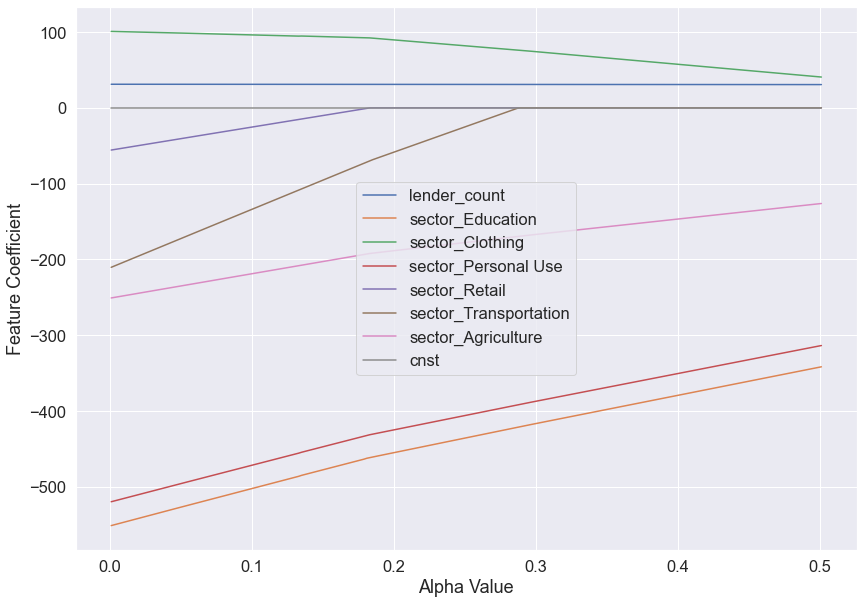

In [61]:
lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_train_lasso.columns):
    plt.plot(alphas, coefs, label = feature);
plt.ylabel('Feature Coefficient');
plt.xlabel('Alpha Value');
plt.legend(loc='best');
plt.show();

Retail and Transportation go to 0 when alpha is 0.3.  Let's try removing these from the model.

In [62]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define the dependent variable
y = df['loan_amount']
# Define the independent variables
X = df[['lender_count', 'sector_Education', 'sector_Clothing', 
        'sector_Personal Use', 'sector_Agriculture']]
# Add an intercept term to the independent variables
X['cnst'] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     4241.
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:12:47   Log-Likelihood:                -40381.
No. Observations:                4815   AIC:                         8.077e+04
Df Residuals:                    4809   BIC:                         8.081e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
lender_count           31.1189    

Even though we removed two dependent variables from the analysis, our R-squared and adjusted R-squared stayed the same.  This means that the two variables we removed (Transportation and Retail) are less important to loan amount.  The example above shows how we can use regularization for feature selection.

# Important facts about regularization

Recall that with least squares linear regression, the coefficients are scale equivariant.  In other words, multiplying a feature by a constant $c$ simply leads to a scaling of the least squares coefficient estimate by a factor of 1/$c$. 

Let's demonstrate this fact by creating a example set of data that has three variables: 1) amount of money made at a restaurant in one day, 2) distance in meters to the nearest university, 3) distance in kilometers to the nearest hospital.

In [63]:
np.random.seed(1234)

earnings = np.random.normal(2000, 300, 50)
university_distances = np.random.normal(7000,2000,50)
hospital_distances = np.random.normal(7,2,50)

earnings = [a if a > 0 else -a for a in earnings]
university_distances = [a if a > 0 else -a for a in university_distances]
hospital_distances = [a if a > 0 else -a for a in hospital_distances]

In [64]:
df = pd.DataFrame({"earnings": sorted(earnings), "university": sorted(university_distances, reverse=True), 
                   'hospital' : sorted(hospital_distances, reverse=True)})

In [65]:
df

,earnings,university,hospital
0,1327.194514,11061.207242,11.731537
1,1377.506720,11015.685902,10.860494
2,1393.623554,10091.317609,10.787069
3,1454.891832,9783.972387,9.726963
4,1535.928334,9642.211231,9.449149
5,1642.707292,9067.601465,9.420767
6,1730.852965,8969.839684,9.353625
7,1783.823380,8682.017590,8.968376
8,1803.209197,8633.187853,8.750951
9,1809.042949,8534.737472,8.632254


Text(0.5, 1.0, 'Scatter plot of distance to nearest university (in meters) vs earnings')

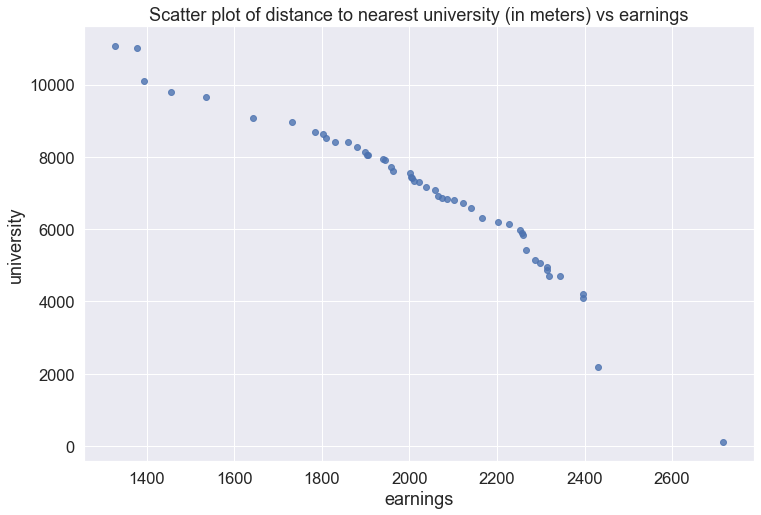

In [66]:
# plot distance to nearest university (in meters) vs. earnings
ax = sns.regplot(x='earnings', y='university', data=df, fit_reg=False)
ax.set_title('Scatter plot of distance to nearest university (in meters) vs earnings')

Text(0.5, 1.0, 'Scatter plot of distance to nearest hospital (in kilometers) vs earnings')

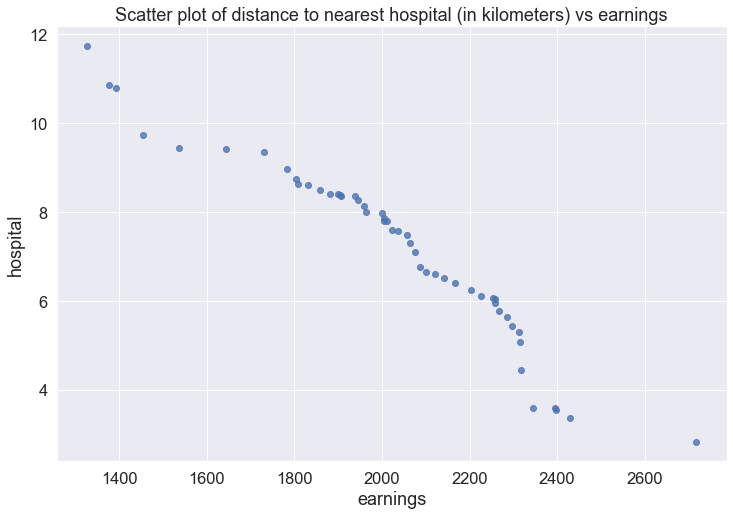

In [67]:
# plot distance to nearest hospital (in kilometers) vs. earnings
ax = sns.regplot(x='earnings', y='hospital', data=df, fit_reg=False)
ax.set_title('Scatter plot of distance to nearest hospital (in kilometers) vs earnings')

Let's run a multivariate linear regression without scaling any variables and compare the results to a model where we standardize the distance variables to both use kilometers.

In [68]:
model1 = smf.ols(formula = 'earnings ~ university + hospital', data = df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     353.0
Date:                Mon, 22 Mar 2021   Prob (F-statistic):           4.90e-29
Time:                        13:12:47   Log-Likelihood:                -284.91
No. Observations:                  50   AIC:                             575.8
Df Residuals:                      47   BIC:                             581.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3024.1009     40.095     75.423      0.0

The R-squared is 0.938 and the Adjusted R-squared is 0.935.  The coefficients for the intercept, university, and hospital are 3024.1009, -0.0643, and -76.3083.  Now let's scale the university variable to be in kilometers instead of meters.

In [69]:
df_scaled = df.copy()
df_scaled['university'] = df_scaled['university']/1000

df_scaled

,earnings,university,hospital
0,1327.194514,11.061207,11.731537
1,1377.506720,11.015686,10.860494
2,1393.623554,10.091318,10.787069
3,1454.891832,9.783972,9.726963
4,1535.928334,9.642211,9.449149
5,1642.707292,9.067601,9.420767
6,1730.852965,8.969840,9.353625
7,1783.823380,8.682018,8.968376
8,1803.209197,8.633188,8.750951
9,1809.042949,8.534737,8.632254


In [71]:
model2 = smf.ols(formula = 'earnings ~ university + hospital', data = df_scaled).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     353.0
Date:                Mon, 22 Mar 2021   Prob (F-statistic):           4.90e-29
Time:                        13:13:57   Log-Likelihood:                -284.91
No. Observations:                  50   AIC:                             575.8
Df Residuals:                      47   BIC:                             581.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3024.1009     40.095     75.423      0.0

The R-squared is 0.938 and the Adjusted R-squared is 0.935. The coefficients for the intercept, university, and hospital are 3024.1009, -64.3473, and -76.3083.   So we changed the university variable by scaling it by a constant and the resulting coefficient was scaled by the same constant.  The p-values did not change and the coefficients on the other variables did not change.

What do you think scaling will do if we incorporate regularization by using lasso or ridge regression?  Do you think scaling will have an effect on the coefficients of the variables?

<br>
<br>
<br>
<br>


Let's run lasso on our unscaled data and our scaled data and see what happens.

# Unscaled data

Lasso(alpha=0.001, normalize=True)

Lasso(alpha=0.003, normalize=True)

Lasso(alpha=0.005, normalize=True)

Lasso(alpha=0.007, normalize=True)

Lasso(alpha=0.009000000000000001, normalize=True)

Lasso(alpha=0.011, normalize=True)

Lasso(alpha=0.013000000000000001, normalize=True)

Lasso(alpha=0.015, normalize=True)

Lasso(alpha=0.017, normalize=True)

Lasso(alpha=0.019000000000000003, normalize=True)

Lasso(alpha=0.021, normalize=True)

Lasso(alpha=0.023, normalize=True)

Lasso(alpha=0.025, normalize=True)

Lasso(alpha=0.027000000000000003, normalize=True)

Lasso(alpha=0.029, normalize=True)

Lasso(alpha=0.031, normalize=True)

Lasso(alpha=0.033, normalize=True)

Lasso(alpha=0.035, normalize=True)

Lasso(alpha=0.037000000000000005, normalize=True)

Lasso(alpha=0.039, normalize=True)

Lasso(alpha=0.041, normalize=True)

Lasso(alpha=0.043000000000000003, normalize=True)

Lasso(alpha=0.045, normalize=True)

Lasso(alpha=0.047, normalize=True)

Lasso(alpha=0.049, normalize=True)

Lasso(alpha=0.051000000000000004, normalize=True)

Lasso(alpha=0.053000000000000005, normalize=True)

Lasso(alpha=0.055, normalize=True)

Lasso(alpha=0.057, normalize=True)

Lasso(alpha=0.059000000000000004, normalize=True)

Lasso(alpha=0.061, normalize=True)

Lasso(alpha=0.063, normalize=True)

Lasso(alpha=0.065, normalize=True)

Lasso(alpha=0.067, normalize=True)

Lasso(alpha=0.069, normalize=True)

Lasso(alpha=0.07100000000000001, normalize=True)

Lasso(alpha=0.07300000000000001, normalize=True)

Lasso(alpha=0.075, normalize=True)

Lasso(alpha=0.077, normalize=True)

Lasso(alpha=0.079, normalize=True)

Lasso(alpha=0.081, normalize=True)

Lasso(alpha=0.083, normalize=True)

Lasso(alpha=0.085, normalize=True)

Lasso(alpha=0.08700000000000001, normalize=True)

Lasso(alpha=0.089, normalize=True)

Lasso(alpha=0.091, normalize=True)

Lasso(alpha=0.093, normalize=True)

Lasso(alpha=0.095, normalize=True)

Lasso(alpha=0.097, normalize=True)

Lasso(alpha=0.099, normalize=True)

Lasso(alpha=0.101, normalize=True)

Lasso(alpha=0.10300000000000001, normalize=True)

Lasso(alpha=0.10500000000000001, normalize=True)

Lasso(alpha=0.107, normalize=True)

Lasso(alpha=0.109, normalize=True)

Lasso(alpha=0.111, normalize=True)

Lasso(alpha=0.113, normalize=True)

Lasso(alpha=0.115, normalize=True)

Lasso(alpha=0.117, normalize=True)

Lasso(alpha=0.11900000000000001, normalize=True)

Lasso(alpha=0.121, normalize=True)

Lasso(alpha=0.123, normalize=True)

Lasso(alpha=0.125, normalize=True)

Lasso(alpha=0.127, normalize=True)

Lasso(alpha=0.129, normalize=True)

Lasso(alpha=0.131, normalize=True)

Lasso(alpha=0.133, normalize=True)

Lasso(alpha=0.135, normalize=True)

Lasso(alpha=0.137, normalize=True)

Lasso(alpha=0.139, normalize=True)

Lasso(alpha=0.14100000000000001, normalize=True)

Lasso(alpha=0.14300000000000002, normalize=True)

Lasso(alpha=0.14500000000000002, normalize=True)

Lasso(alpha=0.147, normalize=True)

Lasso(alpha=0.149, normalize=True)

Lasso(alpha=0.151, normalize=True)

Lasso(alpha=0.153, normalize=True)

Lasso(alpha=0.155, normalize=True)

Lasso(alpha=0.157, normalize=True)

Lasso(alpha=0.159, normalize=True)

Lasso(alpha=0.161, normalize=True)

Lasso(alpha=0.163, normalize=True)

Lasso(alpha=0.165, normalize=True)

Lasso(alpha=0.167, normalize=True)

Lasso(alpha=0.169, normalize=True)

Lasso(alpha=0.171, normalize=True)

Lasso(alpha=0.17300000000000001, normalize=True)

Lasso(alpha=0.17500000000000002, normalize=True)

Lasso(alpha=0.177, normalize=True)

Lasso(alpha=0.179, normalize=True)

Lasso(alpha=0.181, normalize=True)

Lasso(alpha=0.183, normalize=True)

Lasso(alpha=0.185, normalize=True)

Lasso(alpha=0.187, normalize=True)

Lasso(alpha=0.189, normalize=True)

Lasso(alpha=0.191, normalize=True)

Lasso(alpha=0.193, normalize=True)

Lasso(alpha=0.195, normalize=True)

Lasso(alpha=0.197, normalize=True)

Lasso(alpha=0.199, normalize=True)

Lasso(alpha=0.201, normalize=True)

Lasso(alpha=0.203, normalize=True)

Lasso(alpha=0.20500000000000002, normalize=True)

Lasso(alpha=0.20700000000000002, normalize=True)

Lasso(alpha=0.20900000000000002, normalize=True)

Lasso(alpha=0.211, normalize=True)

Lasso(alpha=0.213, normalize=True)

Lasso(alpha=0.215, normalize=True)

Lasso(alpha=0.217, normalize=True)

Lasso(alpha=0.219, normalize=True)

Lasso(alpha=0.221, normalize=True)

Lasso(alpha=0.223, normalize=True)

Lasso(alpha=0.225, normalize=True)

Lasso(alpha=0.227, normalize=True)

Lasso(alpha=0.229, normalize=True)

Lasso(alpha=0.231, normalize=True)

Lasso(alpha=0.233, normalize=True)

Lasso(alpha=0.23500000000000001, normalize=True)

Lasso(alpha=0.23700000000000002, normalize=True)

Lasso(alpha=0.23900000000000002, normalize=True)

Lasso(alpha=0.241, normalize=True)

Lasso(alpha=0.243, normalize=True)

Lasso(alpha=0.245, normalize=True)

Lasso(alpha=0.247, normalize=True)

Lasso(alpha=0.249, normalize=True)

Lasso(alpha=0.251, normalize=True)

Lasso(alpha=0.253, normalize=True)

Lasso(alpha=0.255, normalize=True)

Lasso(alpha=0.257, normalize=True)

Lasso(alpha=0.259, normalize=True)

Lasso(alpha=0.261, normalize=True)

Lasso(alpha=0.263, normalize=True)

Lasso(alpha=0.265, normalize=True)

Lasso(alpha=0.267, normalize=True)

Lasso(alpha=0.269, normalize=True)

Lasso(alpha=0.271, normalize=True)

Lasso(alpha=0.273, normalize=True)

Lasso(alpha=0.275, normalize=True)

Lasso(alpha=0.277, normalize=True)

Lasso(alpha=0.279, normalize=True)

Lasso(alpha=0.281, normalize=True)

Lasso(alpha=0.28300000000000003, normalize=True)

Lasso(alpha=0.28500000000000003, normalize=True)

Lasso(alpha=0.28700000000000003, normalize=True)

Lasso(alpha=0.28900000000000003, normalize=True)

Lasso(alpha=0.291, normalize=True)

Lasso(alpha=0.293, normalize=True)

Lasso(alpha=0.295, normalize=True)

Lasso(alpha=0.297, normalize=True)

Lasso(alpha=0.299, normalize=True)

Lasso(alpha=0.301, normalize=True)

Lasso(alpha=0.303, normalize=True)

Lasso(alpha=0.305, normalize=True)

Lasso(alpha=0.307, normalize=True)

Lasso(alpha=0.309, normalize=True)

Lasso(alpha=0.311, normalize=True)

Lasso(alpha=0.313, normalize=True)

Lasso(alpha=0.315, normalize=True)

Lasso(alpha=0.317, normalize=True)

Lasso(alpha=0.319, normalize=True)

Lasso(alpha=0.321, normalize=True)

Lasso(alpha=0.323, normalize=True)

Lasso(alpha=0.325, normalize=True)

Lasso(alpha=0.327, normalize=True)

Lasso(alpha=0.329, normalize=True)

Lasso(alpha=0.331, normalize=True)

Lasso(alpha=0.333, normalize=True)

Lasso(alpha=0.335, normalize=True)

Lasso(alpha=0.337, normalize=True)

Lasso(alpha=0.339, normalize=True)

Lasso(alpha=0.341, normalize=True)

Lasso(alpha=0.343, normalize=True)

Lasso(alpha=0.34500000000000003, normalize=True)

Lasso(alpha=0.34700000000000003, normalize=True)

Lasso(alpha=0.34900000000000003, normalize=True)

Lasso(alpha=0.35100000000000003, normalize=True)

Lasso(alpha=0.353, normalize=True)

Lasso(alpha=0.355, normalize=True)

Lasso(alpha=0.357, normalize=True)

Lasso(alpha=0.359, normalize=True)

Lasso(alpha=0.361, normalize=True)

Lasso(alpha=0.363, normalize=True)

Lasso(alpha=0.365, normalize=True)

Lasso(alpha=0.367, normalize=True)

Lasso(alpha=0.369, normalize=True)

Lasso(alpha=0.371, normalize=True)

Lasso(alpha=0.373, normalize=True)

Lasso(alpha=0.375, normalize=True)

Lasso(alpha=0.377, normalize=True)

Lasso(alpha=0.379, normalize=True)

Lasso(alpha=0.381, normalize=True)

Lasso(alpha=0.383, normalize=True)

Lasso(alpha=0.385, normalize=True)

Lasso(alpha=0.387, normalize=True)

Lasso(alpha=0.389, normalize=True)

Lasso(alpha=0.391, normalize=True)

Lasso(alpha=0.393, normalize=True)

Lasso(alpha=0.395, normalize=True)

Lasso(alpha=0.397, normalize=True)

Lasso(alpha=0.399, normalize=True)

Lasso(alpha=0.401, normalize=True)

Lasso(alpha=0.403, normalize=True)

Lasso(alpha=0.405, normalize=True)

Lasso(alpha=0.40700000000000003, normalize=True)

Lasso(alpha=0.40900000000000003, normalize=True)

Lasso(alpha=0.41100000000000003, normalize=True)

Lasso(alpha=0.41300000000000003, normalize=True)

Lasso(alpha=0.41500000000000004, normalize=True)

Lasso(alpha=0.41700000000000004, normalize=True)

Lasso(alpha=0.419, normalize=True)

Lasso(alpha=0.421, normalize=True)

Lasso(alpha=0.423, normalize=True)

Lasso(alpha=0.425, normalize=True)

Lasso(alpha=0.427, normalize=True)

Lasso(alpha=0.429, normalize=True)

Lasso(alpha=0.431, normalize=True)

Lasso(alpha=0.433, normalize=True)

Lasso(alpha=0.435, normalize=True)

Lasso(alpha=0.437, normalize=True)

Lasso(alpha=0.439, normalize=True)

Lasso(alpha=0.441, normalize=True)

Lasso(alpha=0.443, normalize=True)

Lasso(alpha=0.445, normalize=True)

Lasso(alpha=0.447, normalize=True)

Lasso(alpha=0.449, normalize=True)

Lasso(alpha=0.451, normalize=True)

Lasso(alpha=0.453, normalize=True)

Lasso(alpha=0.455, normalize=True)

Lasso(alpha=0.457, normalize=True)

Lasso(alpha=0.459, normalize=True)

Lasso(alpha=0.461, normalize=True)

Lasso(alpha=0.463, normalize=True)

Lasso(alpha=0.465, normalize=True)

Lasso(alpha=0.467, normalize=True)

Lasso(alpha=0.46900000000000003, normalize=True)

Lasso(alpha=0.47100000000000003, normalize=True)

Lasso(alpha=0.47300000000000003, normalize=True)

Lasso(alpha=0.47500000000000003, normalize=True)

Lasso(alpha=0.47700000000000004, normalize=True)

Lasso(alpha=0.47900000000000004, normalize=True)

Lasso(alpha=0.481, normalize=True)

Lasso(alpha=0.483, normalize=True)

Lasso(alpha=0.485, normalize=True)

Lasso(alpha=0.487, normalize=True)

Lasso(alpha=0.489, normalize=True)

Lasso(alpha=0.491, normalize=True)

Lasso(alpha=0.493, normalize=True)

Lasso(alpha=0.495, normalize=True)

Lasso(alpha=0.497, normalize=True)

Lasso(alpha=0.499, normalize=True)

Lasso(alpha=0.501, normalize=True)

Lasso(alpha=0.503, normalize=True)

Lasso(alpha=0.505, normalize=True)

Lasso(alpha=0.507, normalize=True)

Lasso(alpha=0.509, normalize=True)

Lasso(alpha=0.511, normalize=True)

Lasso(alpha=0.513, normalize=True)

Lasso(alpha=0.515, normalize=True)

Lasso(alpha=0.517, normalize=True)

Lasso(alpha=0.519, normalize=True)

Lasso(alpha=0.521, normalize=True)

Lasso(alpha=0.523, normalize=True)

Lasso(alpha=0.525, normalize=True)

Lasso(alpha=0.527, normalize=True)

Lasso(alpha=0.529, normalize=True)

Lasso(alpha=0.531, normalize=True)

Lasso(alpha=0.533, normalize=True)

Lasso(alpha=0.535, normalize=True)

Lasso(alpha=0.537, normalize=True)

Lasso(alpha=0.539, normalize=True)

Lasso(alpha=0.541, normalize=True)

Lasso(alpha=0.543, normalize=True)

Lasso(alpha=0.545, normalize=True)

Lasso(alpha=0.547, normalize=True)

Lasso(alpha=0.549, normalize=True)

Lasso(alpha=0.551, normalize=True)

Lasso(alpha=0.553, normalize=True)

Lasso(alpha=0.555, normalize=True)

Lasso(alpha=0.557, normalize=True)

Lasso(alpha=0.559, normalize=True)

Lasso(alpha=0.561, normalize=True)

Lasso(alpha=0.5630000000000001, normalize=True)

Lasso(alpha=0.5650000000000001, normalize=True)

Lasso(alpha=0.5670000000000001, normalize=True)

Lasso(alpha=0.5690000000000001, normalize=True)

Lasso(alpha=0.5710000000000001, normalize=True)

Lasso(alpha=0.5730000000000001, normalize=True)

Lasso(alpha=0.5750000000000001, normalize=True)

Lasso(alpha=0.5770000000000001, normalize=True)

Lasso(alpha=0.579, normalize=True)

Lasso(alpha=0.581, normalize=True)

Lasso(alpha=0.583, normalize=True)

Lasso(alpha=0.585, normalize=True)

Lasso(alpha=0.587, normalize=True)

Lasso(alpha=0.589, normalize=True)

Lasso(alpha=0.591, normalize=True)

Lasso(alpha=0.593, normalize=True)

Lasso(alpha=0.595, normalize=True)

Lasso(alpha=0.597, normalize=True)

Lasso(alpha=0.599, normalize=True)

Lasso(alpha=0.601, normalize=True)

Lasso(alpha=0.603, normalize=True)

Lasso(alpha=0.605, normalize=True)

Lasso(alpha=0.607, normalize=True)

Lasso(alpha=0.609, normalize=True)

Lasso(alpha=0.611, normalize=True)

Lasso(alpha=0.613, normalize=True)

Lasso(alpha=0.615, normalize=True)

Lasso(alpha=0.617, normalize=True)

Lasso(alpha=0.619, normalize=True)

Lasso(alpha=0.621, normalize=True)

Lasso(alpha=0.623, normalize=True)

Lasso(alpha=0.625, normalize=True)

Lasso(alpha=0.627, normalize=True)

Lasso(alpha=0.629, normalize=True)

Lasso(alpha=0.631, normalize=True)

Lasso(alpha=0.633, normalize=True)

Lasso(alpha=0.635, normalize=True)

Lasso(alpha=0.637, normalize=True)

Lasso(alpha=0.639, normalize=True)

Lasso(alpha=0.641, normalize=True)

Lasso(alpha=0.643, normalize=True)

Lasso(alpha=0.645, normalize=True)

Lasso(alpha=0.647, normalize=True)

Lasso(alpha=0.649, normalize=True)

Lasso(alpha=0.651, normalize=True)

Lasso(alpha=0.653, normalize=True)

Lasso(alpha=0.655, normalize=True)

Lasso(alpha=0.657, normalize=True)

Lasso(alpha=0.659, normalize=True)

Lasso(alpha=0.661, normalize=True)

Lasso(alpha=0.663, normalize=True)

Lasso(alpha=0.665, normalize=True)

Lasso(alpha=0.667, normalize=True)

Lasso(alpha=0.669, normalize=True)

Lasso(alpha=0.671, normalize=True)

Lasso(alpha=0.673, normalize=True)

Lasso(alpha=0.675, normalize=True)

Lasso(alpha=0.677, normalize=True)

Lasso(alpha=0.679, normalize=True)

Lasso(alpha=0.681, normalize=True)

Lasso(alpha=0.683, normalize=True)

Lasso(alpha=0.685, normalize=True)

Lasso(alpha=0.687, normalize=True)

Lasso(alpha=0.6890000000000001, normalize=True)

Lasso(alpha=0.6910000000000001, normalize=True)

Lasso(alpha=0.6930000000000001, normalize=True)

Lasso(alpha=0.6950000000000001, normalize=True)

Lasso(alpha=0.6970000000000001, normalize=True)

Lasso(alpha=0.6990000000000001, normalize=True)

Lasso(alpha=0.7010000000000001, normalize=True)

Lasso(alpha=0.7030000000000001, normalize=True)

Lasso(alpha=0.705, normalize=True)

Lasso(alpha=0.707, normalize=True)

Lasso(alpha=0.709, normalize=True)

Lasso(alpha=0.711, normalize=True)

Lasso(alpha=0.713, normalize=True)

Lasso(alpha=0.715, normalize=True)

Lasso(alpha=0.717, normalize=True)

Lasso(alpha=0.719, normalize=True)

Lasso(alpha=0.721, normalize=True)

Lasso(alpha=0.723, normalize=True)

Lasso(alpha=0.725, normalize=True)

Lasso(alpha=0.727, normalize=True)

Lasso(alpha=0.729, normalize=True)

Lasso(alpha=0.731, normalize=True)

Lasso(alpha=0.733, normalize=True)

Lasso(alpha=0.735, normalize=True)

Lasso(alpha=0.737, normalize=True)

Lasso(alpha=0.739, normalize=True)

Lasso(alpha=0.741, normalize=True)

Lasso(alpha=0.743, normalize=True)

Lasso(alpha=0.745, normalize=True)

Lasso(alpha=0.747, normalize=True)

Lasso(alpha=0.749, normalize=True)

Lasso(alpha=0.751, normalize=True)

Lasso(alpha=0.753, normalize=True)

Lasso(alpha=0.755, normalize=True)

Lasso(alpha=0.757, normalize=True)

Lasso(alpha=0.759, normalize=True)

Lasso(alpha=0.761, normalize=True)

Lasso(alpha=0.763, normalize=True)

Lasso(alpha=0.765, normalize=True)

Lasso(alpha=0.767, normalize=True)

Lasso(alpha=0.769, normalize=True)

Lasso(alpha=0.771, normalize=True)

Lasso(alpha=0.773, normalize=True)

Lasso(alpha=0.775, normalize=True)

Lasso(alpha=0.777, normalize=True)

Lasso(alpha=0.779, normalize=True)

Lasso(alpha=0.781, normalize=True)

Lasso(alpha=0.783, normalize=True)

Lasso(alpha=0.785, normalize=True)

Lasso(alpha=0.787, normalize=True)

Lasso(alpha=0.789, normalize=True)

Lasso(alpha=0.791, normalize=True)

Lasso(alpha=0.793, normalize=True)

Lasso(alpha=0.795, normalize=True)

Lasso(alpha=0.797, normalize=True)

Lasso(alpha=0.799, normalize=True)

Lasso(alpha=0.801, normalize=True)

Lasso(alpha=0.803, normalize=True)

Lasso(alpha=0.805, normalize=True)

Lasso(alpha=0.807, normalize=True)

Lasso(alpha=0.809, normalize=True)

Lasso(alpha=0.811, normalize=True)

Lasso(alpha=0.8130000000000001, normalize=True)

Lasso(alpha=0.8150000000000001, normalize=True)

Lasso(alpha=0.8170000000000001, normalize=True)

Lasso(alpha=0.8190000000000001, normalize=True)

Lasso(alpha=0.8210000000000001, normalize=True)

Lasso(alpha=0.8230000000000001, normalize=True)

Lasso(alpha=0.8250000000000001, normalize=True)

Lasso(alpha=0.8270000000000001, normalize=True)

Lasso(alpha=0.8290000000000001, normalize=True)

Lasso(alpha=0.8310000000000001, normalize=True)

Lasso(alpha=0.8330000000000001, normalize=True)

Lasso(alpha=0.835, normalize=True)

Lasso(alpha=0.837, normalize=True)

Lasso(alpha=0.839, normalize=True)

Lasso(alpha=0.841, normalize=True)

Lasso(alpha=0.843, normalize=True)

Lasso(alpha=0.845, normalize=True)

Lasso(alpha=0.847, normalize=True)

Lasso(alpha=0.849, normalize=True)

Lasso(alpha=0.851, normalize=True)

Lasso(alpha=0.853, normalize=True)

Lasso(alpha=0.855, normalize=True)

Lasso(alpha=0.857, normalize=True)

Lasso(alpha=0.859, normalize=True)

Lasso(alpha=0.861, normalize=True)

Lasso(alpha=0.863, normalize=True)

Lasso(alpha=0.865, normalize=True)

Lasso(alpha=0.867, normalize=True)

Lasso(alpha=0.869, normalize=True)

Lasso(alpha=0.871, normalize=True)

Lasso(alpha=0.873, normalize=True)

Lasso(alpha=0.875, normalize=True)

Lasso(alpha=0.877, normalize=True)

Lasso(alpha=0.879, normalize=True)

Lasso(alpha=0.881, normalize=True)

Lasso(alpha=0.883, normalize=True)

Lasso(alpha=0.885, normalize=True)

Lasso(alpha=0.887, normalize=True)

Lasso(alpha=0.889, normalize=True)

Lasso(alpha=0.891, normalize=True)

Lasso(alpha=0.893, normalize=True)

Lasso(alpha=0.895, normalize=True)

Lasso(alpha=0.897, normalize=True)

Lasso(alpha=0.899, normalize=True)

Lasso(alpha=0.901, normalize=True)

Lasso(alpha=0.903, normalize=True)

Lasso(alpha=0.905, normalize=True)

Lasso(alpha=0.907, normalize=True)

Lasso(alpha=0.909, normalize=True)

Lasso(alpha=0.911, normalize=True)

Lasso(alpha=0.913, normalize=True)

Lasso(alpha=0.915, normalize=True)

Lasso(alpha=0.917, normalize=True)

Lasso(alpha=0.919, normalize=True)

Lasso(alpha=0.921, normalize=True)

Lasso(alpha=0.923, normalize=True)

Lasso(alpha=0.925, normalize=True)

Lasso(alpha=0.927, normalize=True)

Lasso(alpha=0.929, normalize=True)

Lasso(alpha=0.931, normalize=True)

Lasso(alpha=0.933, normalize=True)

Lasso(alpha=0.935, normalize=True)

Lasso(alpha=0.937, normalize=True)

Lasso(alpha=0.9390000000000001, normalize=True)

Lasso(alpha=0.9410000000000001, normalize=True)

Lasso(alpha=0.9430000000000001, normalize=True)

Lasso(alpha=0.9450000000000001, normalize=True)

Lasso(alpha=0.9470000000000001, normalize=True)

Lasso(alpha=0.9490000000000001, normalize=True)

Lasso(alpha=0.9510000000000001, normalize=True)

Lasso(alpha=0.9530000000000001, normalize=True)

Lasso(alpha=0.9550000000000001, normalize=True)

Lasso(alpha=0.9570000000000001, normalize=True)

Lasso(alpha=0.9590000000000001, normalize=True)

Lasso(alpha=0.961, normalize=True)

Lasso(alpha=0.963, normalize=True)

Lasso(alpha=0.965, normalize=True)

Lasso(alpha=0.967, normalize=True)

Lasso(alpha=0.969, normalize=True)

Lasso(alpha=0.971, normalize=True)

Lasso(alpha=0.973, normalize=True)

Lasso(alpha=0.975, normalize=True)

Lasso(alpha=0.977, normalize=True)

Lasso(alpha=0.979, normalize=True)

Lasso(alpha=0.981, normalize=True)

Lasso(alpha=0.983, normalize=True)

Lasso(alpha=0.985, normalize=True)

Lasso(alpha=0.987, normalize=True)

Lasso(alpha=0.989, normalize=True)

Lasso(alpha=0.991, normalize=True)

Lasso(alpha=0.993, normalize=True)

Lasso(alpha=0.995, normalize=True)

Lasso(alpha=0.997, normalize=True)

Lasso(alpha=0.999, normalize=True)

<Figure size 1008x720 with 0 Axes>

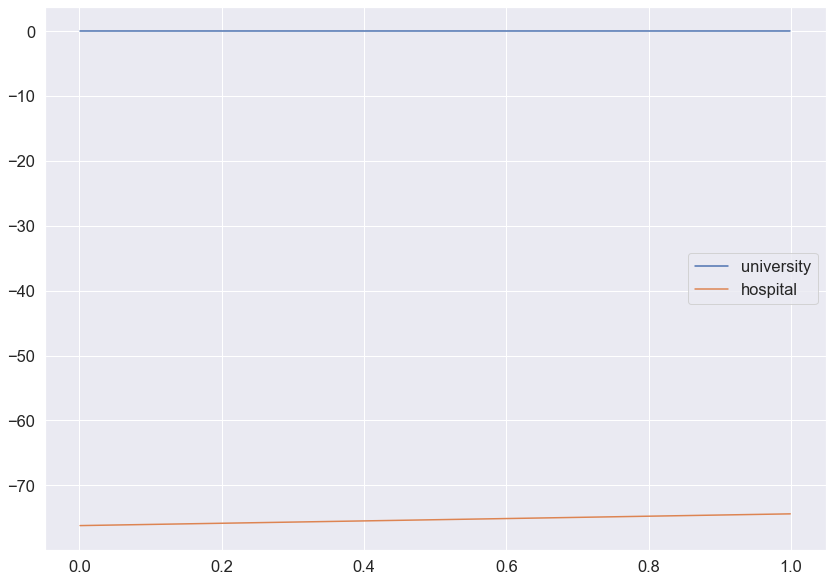

In [72]:
X = df[['university', 'hospital']]
y = df['earnings']

alphas = np.arange(0.001, 1, 0.002)
lasso_coefs = []
X_lasso= X[X.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True, normalize=True)
    lassoreg.fit(X_lasso, y)
    lasso_coefs.append(lassoreg.coef_)
    
lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

The above plot shows the coefficients for the university and hospital variables at 0 and approximately -75, respectively.  Would you keep or drop these variables from your model?  Why?

<br>
<br>
<br>
<br>

# Scaled data

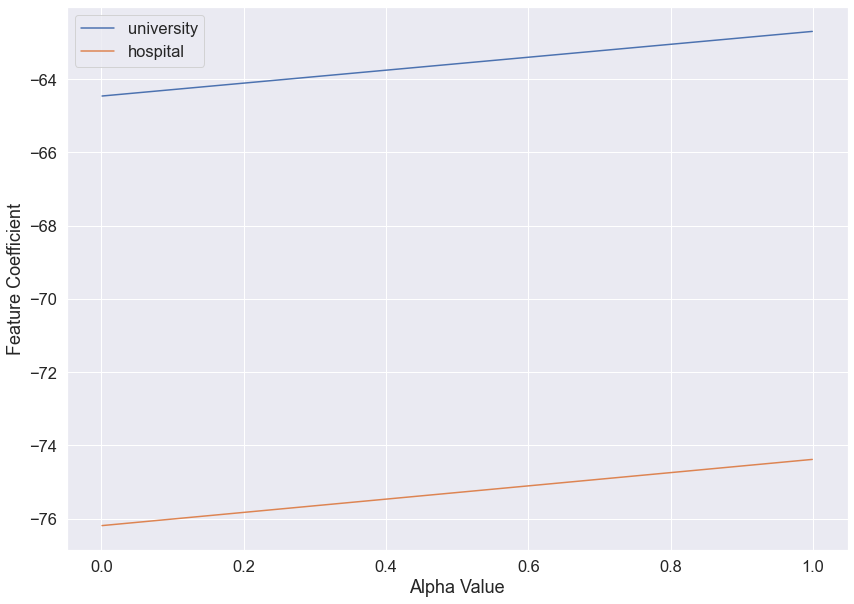

In [73]:
X = df_scaled[['university', 'hospital']]
y = df_scaled['earnings']

alphas = np.arange(0.001, 1, 0.002)
lasso_coefs = []
X_lasso= X[X.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True, normalize=True)
    lassoreg.fit(X_lasso, y)
    lasso_coefs.append(lassoreg.coef_)
    
lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_lasso.columns):
    plt.plot(alphas, coefs, label = feature);
plt.ylabel('Feature Coefficient');
plt.xlabel('Alpha Value');
plt.legend(loc='best');
plt.show();

The above plot shows the coefficient for the university and hospital variables are at around -64 and -76, respectively.  Would you keep or drop these variables from your model?  Why?

<br>
<br>
<br>
<br>

Clearly, scaling affects the coefficients and thus affects the results of lasso regression.  Thus, it is best to apply regularization techniques like ridge and lasso after standardizing the predictors.  You can standardize the predictors by applying the following formula:

$ \tilde{x}_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_{ij} - \bar{x}_{j})^2}} $

So now let's take the unscaled data and make a new dataset where we standardize the predictors.

In [74]:
df_standardized = df.copy()

In [75]:
university_mean = df_standardized['university'].mean()
university_denom = sqrt(sum((df_standardized['university']-university_mean)**2)/len(df_standardized['university']))

hospital_mean = df_standardized['hospital'].mean()
hospital_denom = sqrt(sum((df_standardized['hospital']-hospital_mean)**2)/len(df_standardized['hospital']))

In [76]:
df_standardized['university'] = df_standardized['university']/university_denom
df_standardized['hospital'] = df_standardized['hospital']/hospital_denom


In [77]:
df_standardized

,earnings,university,hospital
0,1327.194514,5.438299,5.926591
1,1377.506720,5.415918,5.486554
2,1393.623554,4.961448,5.449461
3,1454.891832,4.810340,4.913911
4,1535.928334,4.740642,4.773564
5,1642.707292,4.458132,4.759226
6,1730.852965,4.410067,4.725307
7,1783.823380,4.268558,4.530685
8,1803.209197,4.244551,4.420845
9,1809.042949,4.196147,4.360882


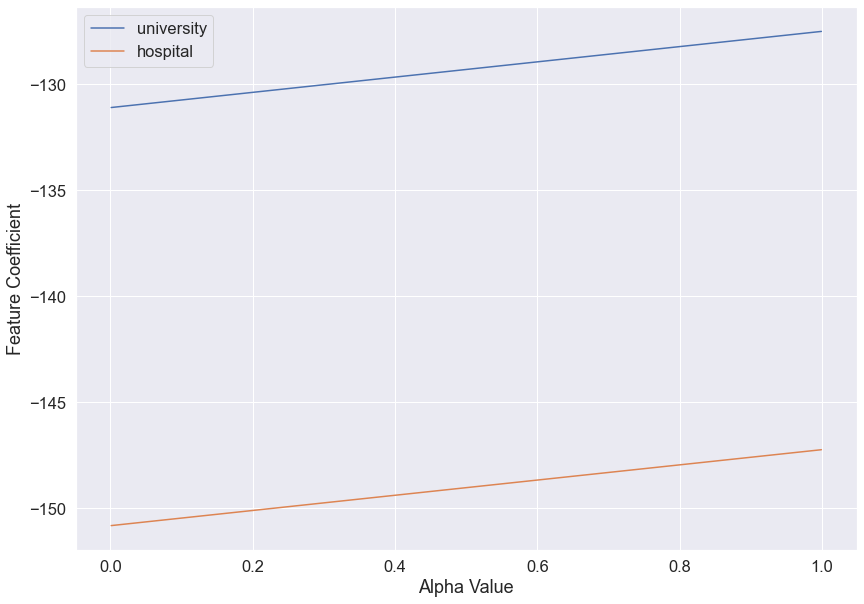

In [78]:
X = df_standardized[['university', 'hospital']]
y = df_standardized['earnings']

alphas = np.arange(0.001, 1, 0.002)
lasso_coefs = []
X_lasso= X[X.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True, normalize=True)
    lassoreg.fit(X_lasso, y)
    lasso_coefs.append(lassoreg.coef_)
    
lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_lasso.columns):
    plt.plot(alphas, coefs, label = feature);
plt.ylabel('Feature Coefficient');
plt.xlabel('Alpha Value');
plt.legend(loc='best');
plt.show();

Now that we've scaled our features, the coefficients are back to being within the same order of magnitude!  Always remember to standardize the features when using regularization.

<br>
<br> 
<br>

----